# Improved Digit Recognition Model

This notebook addresses common overfitting issues in digit recognition models with techniques to ensure the model generalizes well to new images.

In [1]:
# Import libraries
import numpy as np
import splitfolders
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## 1. Dataset Preparation

In [2]:
# Setup paths - update these to match your directory structure
input_folder = "C:/Users/crite/Downloads/digitsData"  # Update this to match your path
output_folder = "preprocessed_digitsData"

# Uncomment to split dataset (70% train, 15% validation, 15% test)
# If you've already split your data, you can leave this commented
'''
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.15, 0.15), 
    group_prefix=None,
    move=False
)
'''

'\nsplitfolders.ratio(\n    input_folder,\n    output=output_folder,\n    seed=42,\n    ratio=(0.7, 0.15, 0.15), \n    group_prefix=None,\n    move=False\n)\n'

## 2. Data Generators with Stronger Augmentation

Enhanced data augmentation helps the model learn more robust features and improves generalization.

In [3]:
# Common parameters for all generators
target_size = (64, 64)
color_mode = 'grayscale'
batch_size = 32
class_mode = 'categorical'

# Training generator with stronger augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # ±15 degrees rotation
    width_shift_range=0.15,  # ±15% horizontal shift
    height_shift_range=0.15, # ±15% vertical shift
    shear_range=0.1,         # Shear transformations
    zoom_range=0.15,         # ±15% zoom
    brightness_range=[0.8, 1.2]  # ±20% brightness variation
)

# Validation and Test generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_folder, 'train'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'val'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(output_folder, 'test'),
    target_size=target_size,
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False  # Keep false for consistent evaluation
)

Found 1433 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 316 images belonging to 10 classes.


## 3. Visualize Augmented Images

Verify that our augmentation is working correctly

Training samples (with augmentation):


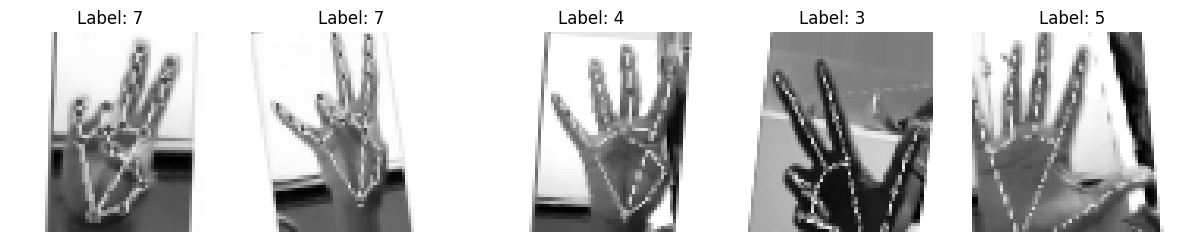

Validation samples (no augmentation):


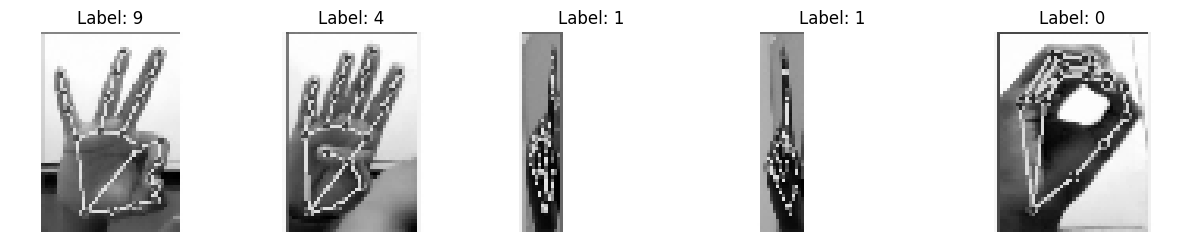

In [4]:
def visualize_augmentations(generator, num_images=5):
    x, y = generator.next()
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x[i].squeeze(), cmap='gray')
        plt.title(f"Label: {list(generator.class_indices.keys())[np.argmax(y[i])]}")
        plt.axis('off')
    plt.show()

print("Training samples (with augmentation):")
visualize_augmentations(train_generator)

print("Validation samples (no augmentation):")
visualize_augmentations(val_generator)

## 4. Improved Model Architecture

This model architecture has several anti-overfitting techniques:
- BatchNormalization to normalize activations
- Multiple dropout layers with progressive rates
- L2 regularization on all convolutional and dense layers
- Simpler architecture with appropriate complexity

In [5]:
# Clear any existing models from memory
import tensorflow as tf
tf.keras.backend.clear_session()

# Create a model with regularization to prevent overfitting
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 1),
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    # Third convolutional block - only if needed
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    
    # Flatten and dense layers
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       2

## 5. Training with Advanced Callbacks

We use multiple callbacks to ensure we get the best possible model:
- Early stopping to prevent overfitting
- Model checkpointing to save the best model
- Learning rate reduction to fine-tune training

In [12]:
# Callbacks for better training
callbacks = [
    # Early stopping to prevent overfitting
    # EarlyStopping(
    #     monitor='val_loss',
    #     patience=5,
    #     restore_best_weights=True,
    #     verbose=1
    # ),
    
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        'best_digit_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate when training plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Train for more epochs, early stopping will prevent overfitting
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
45/45 [==============================] - ETA: 0s - loss: 0.8967 - accuracy: 0.7523
Epoch 1: val_accuracy improved from -inf to 0.92763, saving model to best_digit_model.h5
45/45 [==============================] - 3s 76ms/step - loss: 0.8967 - accuracy: 0.7523 - val_loss: 0.4635 - val_accuracy: 0.9276 - lr: 8.0000e-06
Epoch 2/20
45/45 [==============================] - ETA: 0s - loss: 0.8488 - accuracy: 0.7739
Epoch 2: val_accuracy did not improve from 0.92763
45/45 [==============================] - 4s 79ms/step - loss: 0.8488 - accuracy: 0.7739 - val_loss: 0.4623 - val_accuracy: 0.9276 - lr: 8.0000e-06
Epoch 3/20
45/45 [==============================] - ETA: 0s - loss: 0.9085 - accuracy: 0.7585
Epoch 3: val_accuracy did not improve from 0.92763
45/45 [==============================] - 3s 71ms/step - loss: 0.9085 - accuracy: 0.7585 - val_loss: 0.4606 - val_accuracy: 0.9276 - lr: 8.0000e-06
Epoch 4/20
45/45 [==============================] - ETA: 0s - loss: 0.8618 - accuracy:

## 6. Evaluation and Visualization


Test Set Evaluation:
10/10 [==============================] - 0s 19ms/step - loss: 0.4008 - accuracy: 0.9589
Test Accuracy: 95.89%


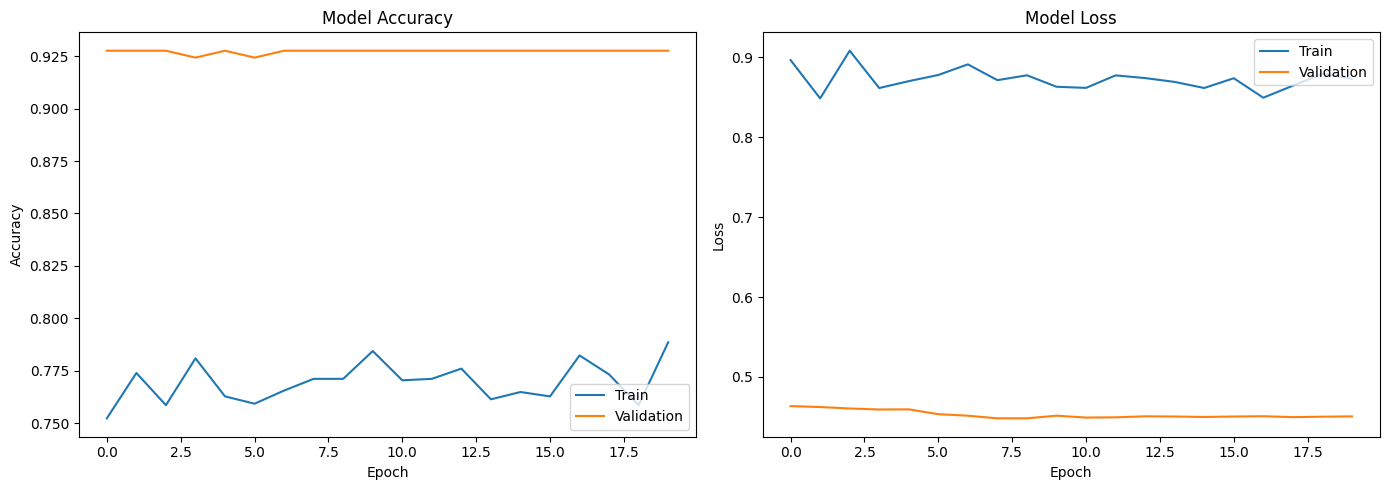

In [13]:
# Evaluate on test set
print("\nTest Set Evaluation:")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2%}")

# Plot training & validation accuracy/loss
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 7. Load the Best Model

Even with early stopping, it's best to explicitly load the best model that was saved during training.

In [19]:
# Load the best model that was saved during training
best_model = load_model('best_hand_gesture_model.h5')

# Evaluate again using the best model
print("Best Model Evaluation:")
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2%}")

Best Model Evaluation:


InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "/opt/anaconda3/envs/tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/envs/tf/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/anaconda3/envs/tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/anaconda3/envs/tf/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/yf/20z1hn994jd04q4kl0gpgh740000gn/T/ipykernel_9722/2650620436.py", line 6, in <module>
      test_loss, test_acc = best_model.evaluate(test_generator)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 2072, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1852, in test_function
      return step_function(self, iterator)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1836, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1824, in run_step
      outputs = model.test_step(data)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 1788, in test_step
      y_pred = self(x, training=False)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/opt/anaconda3/envs/tf/lib/python3.8/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [32,4096], In[1]: [16384,256]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_test_function_20830]

## 8. Prediction Utility Functions

These functions help properly preprocess and predict new images using the same preprocessing as training.

In [15]:
def preprocess_image(image_path, target_size=(64, 64)):
    """Preprocess an image file for prediction, exactly as during training"""
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
        
    # Resize
    img = cv2.resize(img, target_size)
    
    # Normalize [0,255] -> [0,1]
    img = img / 255.0
    
    # Add batch and channel dimensions
    img = np.expand_dims(img, axis=[0, -1])
    
    return img

def predict_and_visualize(image_path, model):
    """Predict and visualize results for a single image"""
    # Preprocess the image
    processed_img = preprocess_image(image_path)
    
    # Make prediction
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    
    # Get class labels from the generator
    class_indices = {v: k for k, v in train_generator.class_indices.items()}
    predicted_label = class_indices.get(predicted_class, str(predicted_class))
    
    # Plot original image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_img[0, :, :, 0], cmap='gray')
    plt.title(f"Predicted: {predicted_label} (Class {predicted_class})\nConfidence: {confidence:.2%}")
    plt.axis('off')
    plt.show()
    
    # Show prediction distribution
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(prediction[0])), prediction[0])
    plt.title('Prediction Confidence by Class')
    plt.xlabel('Class')
    plt.ylabel('Confidence')
    plt.xticks(range(len(prediction[0])))
    plt.tight_layout()
    plt.show()
    
    return predicted_class, confidence

## 9. Test Predictions

Now you can use the functions above to test predictions on new images. To use it, replace the image path with the path to your test image.

In [16]:
# Uncomment and replace with your test image path
# test_image_path = "path/to/your/test/image.jpg"
# predicted_class, confidence = predict_and_visualize(test_image_path, best_model)
# print(f"Predicted class: {predicted_class}, Confidence: {confidence:.2%}")

## 11. Save The Final Model

In [17]:
# Save the model for later use
best_model.save('final_digit_recognition_model.h5')
print("Model saved as 'final_digit_recognition_model.h5'")

Model saved as 'final_digit_recognition_model.h5'


## 12. Examining Problem Cases

Let's identify and analyze cases where the model is likely to make mistakes

1/1 [==============================] - 0s 24ms/step


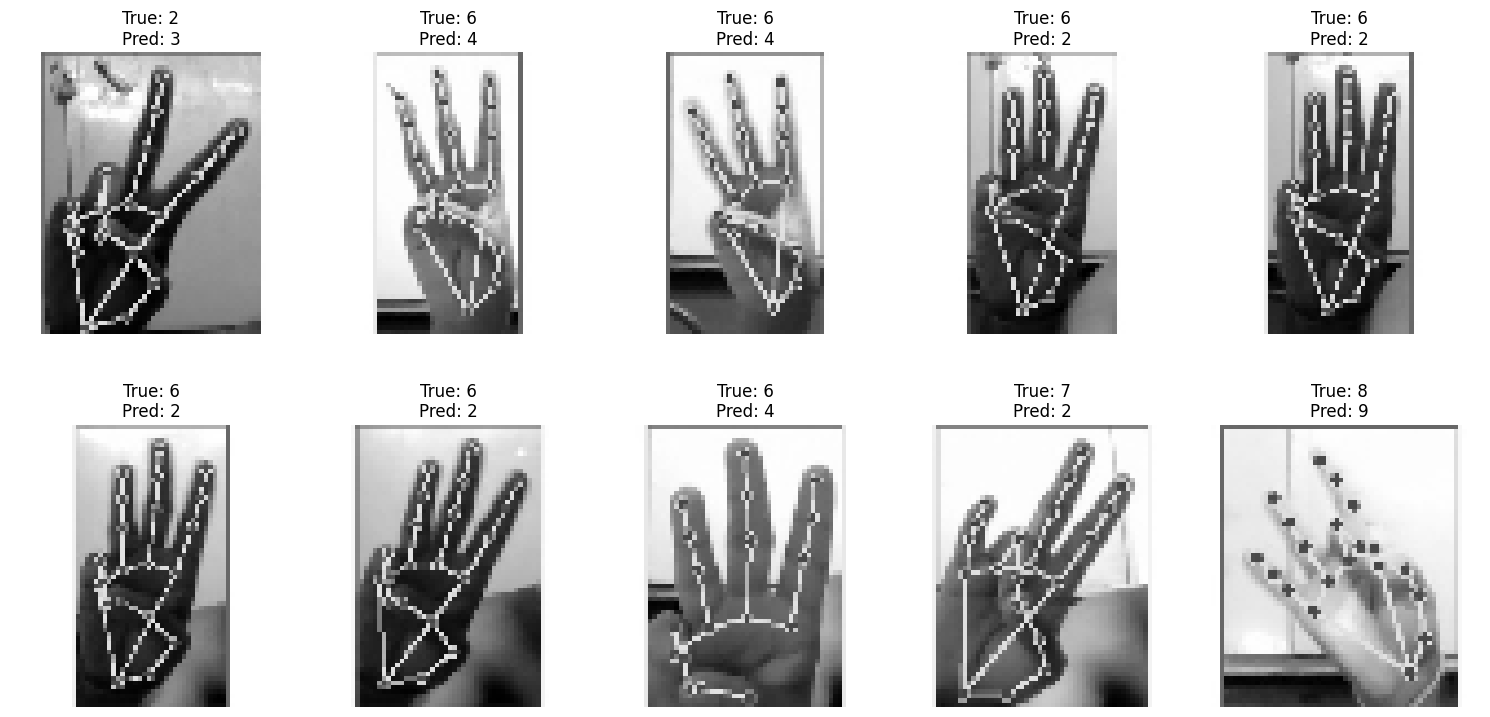

In [18]:
def find_misclassified(model, data_generator, num_to_show=10):
    """Find misclassified examples from a data generator"""
    # Reset the generator
    data_generator.reset()
    
    # Collect all batches
    all_images = []
    all_labels = []
    all_preds = []
    
    # Get a batch of images and labels
    batch_num = 0
    misclassified_indices = []
    misclassified_img = []
    true_labels = []
    pred_labels = []
    
    for X_batch, y_batch in data_generator:
        # Get predictions
        preds = model.predict(X_batch)
        pred_classes = np.argmax(preds, axis=1)
        true_classes = np.argmax(y_batch, axis=1)
        
        # Find misclassified examples
        for i in range(len(pred_classes)):
            if pred_classes[i] != true_classes[i]:
                misclassified_indices.append(batch_num * data_generator.batch_size + i)
                misclassified_img.append(X_batch[i])
                true_labels.append(true_classes[i])
                pred_labels.append(pred_classes[i])
                
                if len(misclassified_img) >= num_to_show:
                    break
        
        batch_num += 1
        if len(misclassified_img) >= num_to_show or batch_num >= data_generator.n // data_generator.batch_size:
            break
    
    # Convert class indices to class names
    class_indices = {v: k for k, v in data_generator.class_indices.items()}
    
    # Visualize misclassified examples
    num_to_display = min(num_to_show, len(misclassified_img))
    fig, axes = plt.subplots(2, (num_to_display+1)//2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(num_to_display):
        axes[i].imshow(misclassified_img[i].squeeze(), cmap='gray')
        true_class = class_indices.get(true_labels[i], str(true_labels[i]))
        pred_class = class_indices.get(pred_labels[i], str(pred_labels[i]))
        axes[i].set_title(f"True: {true_class}\nPred: {pred_class}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return misclassified_indices, misclassified_img, true_labels, pred_labels

# Find and display misclassified examples from the test set
indices, images, true_labels, pred_labels = find_misclassified(best_model, test_generator)

## 13. Real-Time Prediction (For Testing)

This function allows you to use your webcam to capture and recognize digits in real-time.

In [ ]:
def real_time_prediction(model, class_indices=None):
    """Capture from webcam and predict in real-time"""
    # If class_indices not provided, try to use the generator's
    if class_indices is None:
        class_indices = {v: k for k, v in train_generator.class_indices.items()}
    
    # Start webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    try:
        while True:
            # Read frame
            ret, frame = cap.read()
            if not ret:
                print("Error: Could not read frame.")
                break
            
            # Prepare ROI (region of interest) - center square region
            height, width = frame.shape[:2]
            roi_size = min(height, width) // 2
            x_center = width // 2
            y_center = height // 2
            roi = frame[y_center-roi_size//2:y_center+roi_size//2, 
                       x_center-roi_size//2:x_center+roi_size//2]
            
            # Draw ROI rectangle
            cv2.rectangle(frame, 
                         (x_center-roi_size//2, y_center-roi_size//2),
                         (x_center+roi_size//2, y_center+roi_size//2),
                         (0, 255, 0), 2)
            
            # Process ROI for prediction
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_resized = cv2.resize(roi_gray, (64, 64))
            roi_normalized = roi_resized / 255.0
            roi_input = np.expand_dims(roi_normalized, axis=[0, -1])
            
            # Make prediction
            prediction = model.predict(roi_input, verbose=0)
            predicted_class = np.argmax(prediction[0])
            confidence = np.max(prediction[0])
            
            # Get class label
            predicted_label = class_indices.get(predicted_class, str(predicted_class))
            
            # Display result on frame
            text = f"Prediction: {predicted_label} ({confidence:.2%})"
            cv2.putText(frame, text, (10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            
            # Show frame
            cv2.imshow('Digit Recognition', frame)
            
            # Break loop with 'q' key
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
    finally:
        # Release resources
        cap.release()
        cv2.destroyAllWindows()

# Uncomment to use webcam for real-time digit recognition
# real_time_prediction(best_model)

## Summary

This notebook provides an improved approach to digit recognition that prevents overfitting while maintaining high accuracy. Key improvements include:

1. Enhanced data augmentation to improve generalization
2. Regularization techniques (L2, Dropout, BatchNormalization)
3. Appropriate model complexity to avoid overfitting
4. Advanced training callbacks to ensure optimal model selection
5. Consistent preprocessing between training and inference
6. Analysis tools to identify and understand problem cases

These strategies should help fix the issue of high accuracy but incorrect predictions.